In [7]:
from google.colab import drive
from google.colab import auth
from google.auth import default
import os

# Attempt to unmount the drive if it's already mounted and remove the directory
try:
  drive.flush_and_unmount()
except ValueError:
  pass # Drive was not mounted, continue

# Explicitly remove and recreate the mount point directory
if os.path.exists('/content/drive/'):
    os.system('rm -rf /content/drive/')
os.makedirs('/content/drive/', exist_ok=True)

drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


### Setup

In [8]:
# Paths
CSV  = "/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/processed/metadata.csv"
RUNS = "/content/drive/MyDrive/HyacinthWatch_workspace/HyacinthWatch_data/runs"
PRES_W = f"{RUNS}/presence_mobilenetv2.pt"
SEG_W  = f"{RUNS}/unet_resnet34_aquavplant.pt"

# Installs (only needed once per session)
!pip -q install segmentation-models-pytorch==0.3.3 timm==0.9.2 albumentations==1.4.7 --no-cache-dir

import os, json, numpy as np, pandas as pd, torch, torch.nn as nn
from PIL import Image, ImageFilter, ImageEnhance
import matplotlib.pyplot as plt
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, f1_score
import segmentation_models_pytorch as smp

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
df = pd.read_csv(CSV)
pd.set_option('display.max_columns', None)
display(df.head())

Device: cpu


,image_path,mask_path,has_hyacinth,source,split,species_name,base_stem
0,/content/drive/MyDrive/HyacinthWatch_workspace...,/content/drive/MyDrive/HyacinthWatch_workspace...,1,aquavplant,train,NaN,NaN
1,/content/drive/MyDrive/HyacinthWatch_workspace...,/content/drive/MyDrive/HyacinthWatch_workspace...,1,aquavplant,val,NaN,NaN
2,/content/drive/MyDrive/HyacinthWatch_workspace...,/content/drive/MyDrive/HyacinthWatch_workspace...,1,aquavplant,train,NaN,NaN
3,/content/drive/MyDrive/HyacinthWatch_workspace...,/content/drive/MyDrive/HyacinthWatch_workspace...,1,aquavplant,train,NaN,NaN
4,/content/drive/MyDrive/HyacinthWatch_workspace...,/content/drive/MyDrive/HyacinthWatch_workspace...,1,aquavplant,train,NaN,NaN


### Datasets for val/test

In [9]:
# Presence (Bangladesh)
SIZE_CLS = 224
tfm_eval_cls = A.Compose([
    A.LongestMaxSize(max_size=SIZE_CLS),
    A.PadIfNeeded(min_height=SIZE_CLS, min_width=SIZE_CLS, border_mode=0, value=(128,128,128)),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

val_cls_df  = df.query("source=='bangladesh_augmented' and split=='val'").reset_index(drop=True)
test_cls_df = df.query("source=='bangladesh_augmented' and split=='test'").reset_index(drop=True)

# Segmentation (AqUavPlant)
SIZE_SEG = 512
tfm_eval_seg = A.Compose([
    A.LongestMaxSize(max_size=SIZE_SEG),
    A.PadIfNeeded(min_height=SIZE_SEG, min_width=SIZE_SEG, border_mode=0, value=(128,128,128), mask_value=0),
    A.Normalize(mean=(0.485,0.456,0.406), std=(0.229,0.224,0.225))
])

val_seg_df  = df.query("source=='aquavplant' and split=='val'").reset_index(drop=True)
test_seg_df = df.query("source=='aquavplant' and split=='test'").reset_index(drop=True)

len(val_cls_df), len(test_cls_df), len(val_seg_df), len(test_seg_df)

(643, 804, 27, 31)

### Reload Trained Weights

In [10]:
# Presence model
presence_model = torch.hub.load('pytorch/vision:v0.14.1','mobilenet_v2', pretrained=False)
presence_model.classifier[1] = nn.Linear(presence_model.last_channel, 1)
presence_model.load_state_dict(torch.load(PRES_W, map_location=device))
presence_model = presence_model.to(device).eval()

# Segmentation model
seg_model = smp.Unet(encoder_name="resnet34", encoder_weights=None, in_channels=3, classes=1)
seg_model.load_state_dict(torch.load(SEG_W, map_location=device))
seg_model = seg_model.to(device).eval()

# Load best threshold if saved
TH = 0.5
pth = Path(RUNS)/"presence_threshold.json"
if pth.exists():
    TH = json.load(open(pth))["f1"]  # or "youden_j"
print("Using presence threshold:", TH)


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.14.1
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Using presence threshold: 0.9


### Define Robustness Degradations


In [11]:
def corrupt(img: Image.Image, *, blur=0, brightness=1.0, contrast=1.0, noise=0.0, jpeg_q=None):
    out = img
    if blur and blur > 0:
        out = out.filter(ImageFilter.GaussianBlur(radius=float(blur)))
    if brightness != 1.0:
        out = ImageEnhance.Brightness(out).enhance(float(brightness))
    if contrast != 1.0:
        out = ImageEnhance.Contrast(out).enhance(float(contrast))
    if noise and noise > 0:
        arr = np.array(out).astype(np.float32)
        arr += np.random.normal(0, noise*255.0, arr.shape)
        arr = np.clip(arr, 0, 255).astype(np.uint8)
        out = Image.fromarray(arr)
    if jpeg_q is not None:
        from io import BytesIO
        buf = BytesIO(); out.save(buf, format="JPEG", quality=int(jpeg_q))
        buf.seek(0); out = Image.open(buf).convert("RGB")
    return out

def pil_to_tensor_cls(img_pil):
    # Apply same resize/pad/normalize as tfm_eval_cls
    img = np.array(img_pil)
    aug = tfm_eval_cls(image=img)
    x = aug["image"].transpose(2,0,1) if isinstance(aug["image"], np.ndarray) else aug["image"].permute(2,0,1).cpu().numpy()
    x = torch.tensor(x, dtype=torch.float32)
    return x

def pil_to_tensor_seg(img_pil, mask_pil):
    img = np.array(img_pil); msk = np.array(mask_pil)
    if msk.max() > 1: msk = (msk > 127).astype("uint8")
    aug = tfm_eval_seg(image=img, mask=msk)
    x = aug["image"].transpose(2,0,1) if isinstance(aug["image"], np.ndarray) else aug["image"].permute(2,0,1).cpu().numpy()
    y = aug["mask"][None, ...] if isinstance(aug["mask"], np.ndarray) else aug["mask"].unsqueeze(0).cpu().numpy()
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


### Presence robustness (VAL): blur, brightness, noise, JPEG


=== Evaluating presence robustness: blur ===
→ Testing blur = 0
   Finished blur=0 → acc=0.781, auc=0.885
→ Testing blur = 1
   Finished blur=1 → acc=0.603, auc=0.887
→ Testing blur = 2
   Finished blur=2 → acc=0.400, auc=0.826
→ Testing blur = 3
   Finished blur=3 → acc=0.274, auc=0.768
→ Testing blur = 4
   Finished blur=4 → acc=0.263, auc=0.738

=== Evaluating presence robustness: brightness ===
→ Testing brightness = 0.6
   Finished brightness=0.6 → acc=0.756, auc=0.764
→ Testing brightness = 0.8
   Finished brightness=0.8 → acc=0.820, auc=0.858
→ Testing brightness = 1.0
   Finished brightness=1.0 → acc=0.781, auc=0.885
→ Testing brightness = 1.2
   Finished brightness=1.2 → acc=0.729, auc=0.874
→ Testing brightness = 1.4
   Finished brightness=1.4 → acc=0.670, auc=0.827

=== Evaluating presence robustness: noise ===
→ Testing noise = 0.0
   Finished noise=0.0 → acc=0.781, auc=0.885
→ Testing noise = 0.02
   Finished noise=0.02 → acc=0.698, auc=0.811
→ Testing noise = 0.04
   Fin

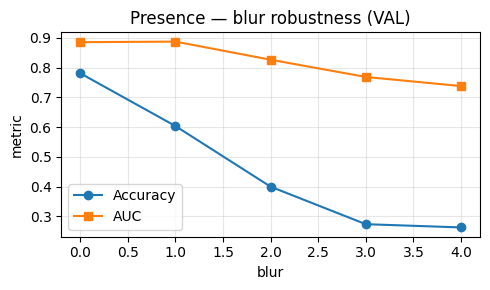

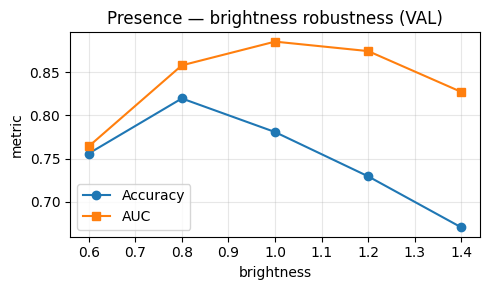

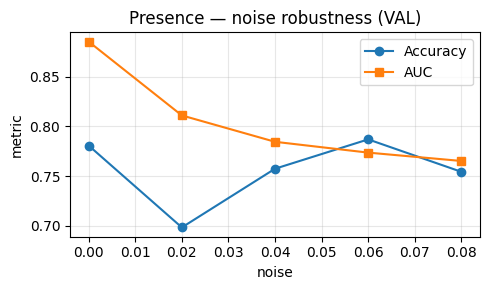

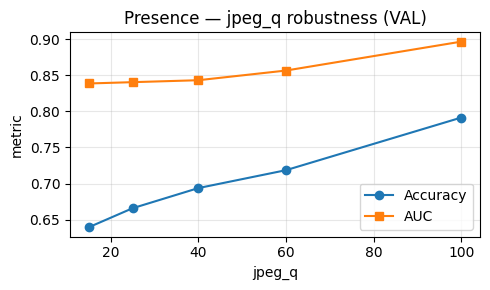

In [12]:
def eval_presence_under(model, rows, *, blur=0, brightness=1.0, contrast=1.0, noise=0.0, jpeg_q=None, thresh=0.5):
    ys, ps = [], []
    model.eval()
    total = len(rows)
    with torch.no_grad():
        for i, (_, r) in enumerate(rows.iterrows(), 1):
            if i % 50 == 0 or i == total:
                print(f"  [{i}/{total}] processing...", end="\r")
            img = Image.open(r.image_path).convert("RGB").resize((SIZE_CLS, SIZE_CLS))
            img = corrupt(img, blur=blur, brightness=brightness, contrast=contrast, noise=noise, jpeg_q=jpeg_q)
            x = pil_to_tensor_cls(img).unsqueeze(0).to(device)
            p = torch.sigmoid(model(x)).item()
            ys.append(int(r.has_hyacinth)); ps.append(p)
    ys, ps = np.array(ys), np.array(ps)
    acc = accuracy_score(ys, ps > thresh)
    auc = roc_auc_score(ys, ps)
    return acc, auc

levels = {
    "blur":       [0, 1, 2, 3, 4],
    "brightness": [0.6, 0.8, 1.0, 1.2, 1.4],
    "noise":      [0.0, 0.02, 0.04, 0.06, 0.08],
    "jpeg_q":     [100, 60, 40, 25, 15],
}

results_cls = {}
for name, vals in levels.items():
    print(f"\n=== Evaluating presence robustness: {name} ===")
    accs, aucs = [], []
    for v in vals:
        kw = {name: v} if name != "jpeg_q" else {"jpeg_q": v}
        print(f"→ Testing {name} = {v}")
        acc, auc = eval_presence_under(presence_model, val_cls_df, **kw, thresh=TH)
        print(f"   Finished {name}={v} → acc={acc:.3f}, auc={auc:.3f}")
        accs.append(acc); aucs.append(auc)
    results_cls[name] = (vals, accs, aucs)

# Plots
for name,(xs, accs, aucs) in results_cls.items():
    plt.figure(figsize=(5,3))
    plt.plot(xs, accs, marker="o", label="Accuracy")
    plt.plot(xs, aucs, marker="s", label="AUC")
    plt.title(f"Presence — {name} robustness (VAL)")
    plt.xlabel(name); plt.ylabel("metric"); plt.legend(); plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()


### Segmentation robustness (VAL): blur/brightness/noise/JPEG with IoU


=== Evaluating segmentation robustness: blur ===
→ Testing blur = 0
   Finished blur=0 → mean IoU=0.619
→ Testing blur = 1
   Finished blur=1 → mean IoU=0.594
→ Testing blur = 2
   Finished blur=2 → mean IoU=0.448
→ Testing blur = 3
   Finished blur=3 → mean IoU=0.143
→ Testing blur = 4
   Finished blur=4 → mean IoU=0.049

=== Evaluating segmentation robustness: brightness ===
→ Testing brightness = 0.6
   Finished brightness=0.6 → mean IoU=0.550
→ Testing brightness = 0.8
   Finished brightness=0.8 → mean IoU=0.621
→ Testing brightness = 1.0
   Finished brightness=1.0 → mean IoU=0.619
→ Testing brightness = 1.2
   Finished brightness=1.2 → mean IoU=0.599
→ Testing brightness = 1.4
   Finished brightness=1.4 → mean IoU=0.551

=== Evaluating segmentation robustness: noise ===
→ Testing noise = 0.0
   Finished noise=0.0 → mean IoU=0.619
→ Testing noise = 0.02
   Finished noise=0.02 → mean IoU=0.613
→ Testing noise = 0.04
   Finished noise=0.04 → mean IoU=0.596
→ Testing noise = 0.06
   

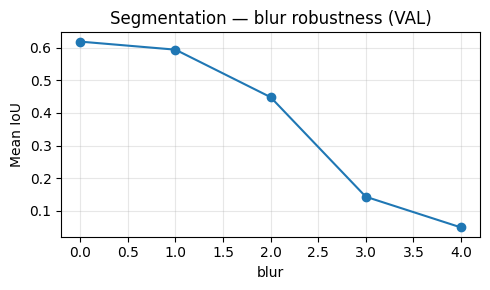

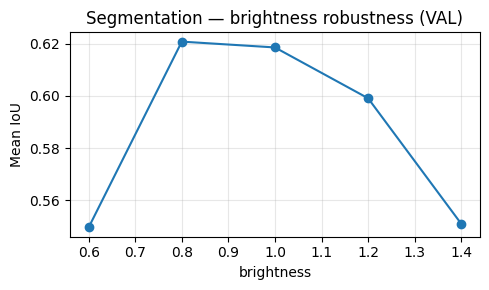

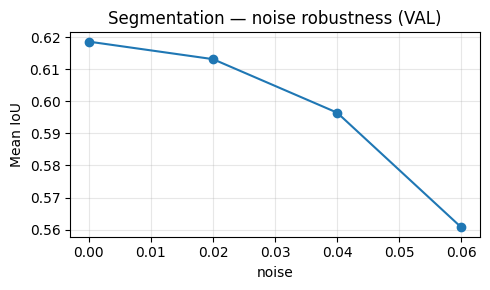

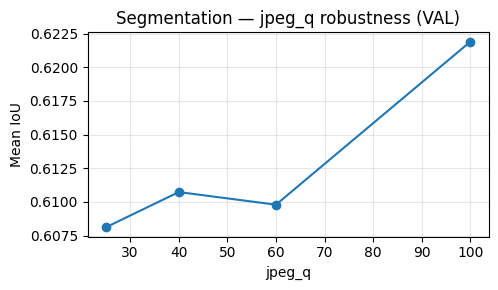

In [13]:
def iou_from_logits(logits, target, thresh=0.4, eps=1e-7):
    prob = torch.sigmoid(logits)
    pred = (prob > thresh).float()
    inter = (pred*target).sum()
    union = pred.sum() + target.sum() - inter
    return float((inter+eps)/(union+eps))

def eval_seg_under(model, rows, *, blur=0, brightness=1.0, contrast=1.0, noise=0.0, jpeg_q=None, thresh=0.4):
    ious=[]
    model.eval()
    total = len(rows)
    with torch.no_grad():
        for i, (_, r) in enumerate(rows.iterrows(), 1):
            if i % 20 == 0 or i == total:
                print(f"  [{i}/{total}] evaluating...", end="\r")
            img = Image.open(r.image_path).convert("RGB")
            msk = Image.open(r.mask_path).convert("L")
            img = corrupt(img, blur=blur, brightness=brightness, contrast=contrast, noise=noise, jpeg_q=jpeg_q)
            x, y = pil_to_tensor_seg(img, msk)
            x = x.unsqueeze(0).to(device); y = y.to(device)
            logits = model(x)
            ious.append(iou_from_logits(logits, y, thresh=thresh))
    mean_iou = float(np.mean(ious)) if ious else 0.0
    return mean_iou

levels_seg = {
    "blur":       [0, 1, 2, 3, 4],
    "brightness": [0.6, 0.8, 1.0, 1.2, 1.4],
    "noise":      [0.0, 0.02, 0.04, 0.06],
    "jpeg_q":     [100, 60, 40, 25],
}

results_seg = {}
for name, vals in levels_seg.items():
    print(f"\n=== Evaluating segmentation robustness: {name} ===")
    scores=[]
    for v in vals:
        kw = {name: v} if name != "jpeg_q" else {"jpeg_q": v}
        print(f"→ Testing {name} = {v}")
        iou = eval_seg_under(seg_model, val_seg_df, **kw, thresh=0.4)
        print(f"   Finished {name}={v} → mean IoU={iou:.3f}")
        scores.append(iou)
    results_seg[name] = (vals, scores)

# Plots
for name,(xs, ys) in results_seg.items():
    plt.figure(figsize=(5,3))
    plt.plot(xs, ys, marker="o")
    plt.title(f"Segmentation — {name} robustness (VAL)")
    plt.xlabel(name); plt.ylabel("Mean IoU")
    plt.grid(True, alpha=0.3); plt.tight_layout(); plt.show()

### Quick side-by-side visuals (clean vs degraded)

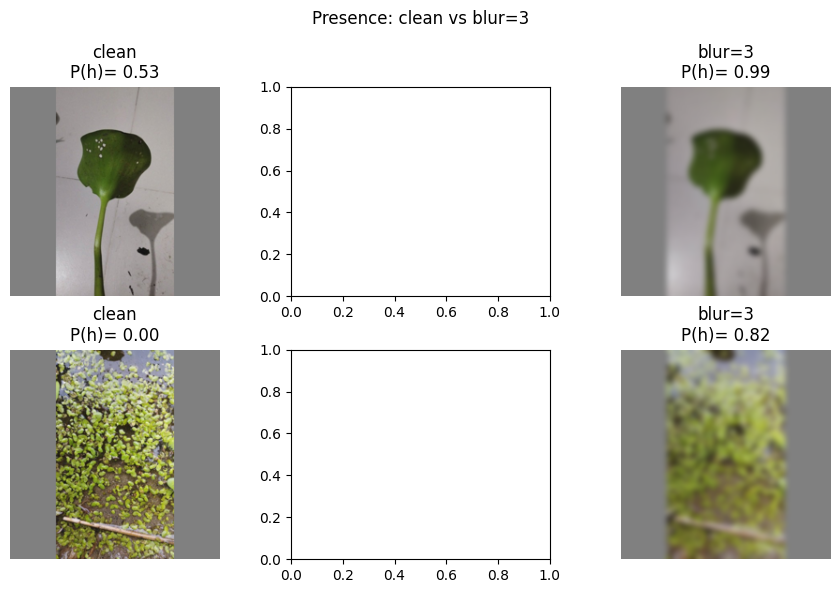

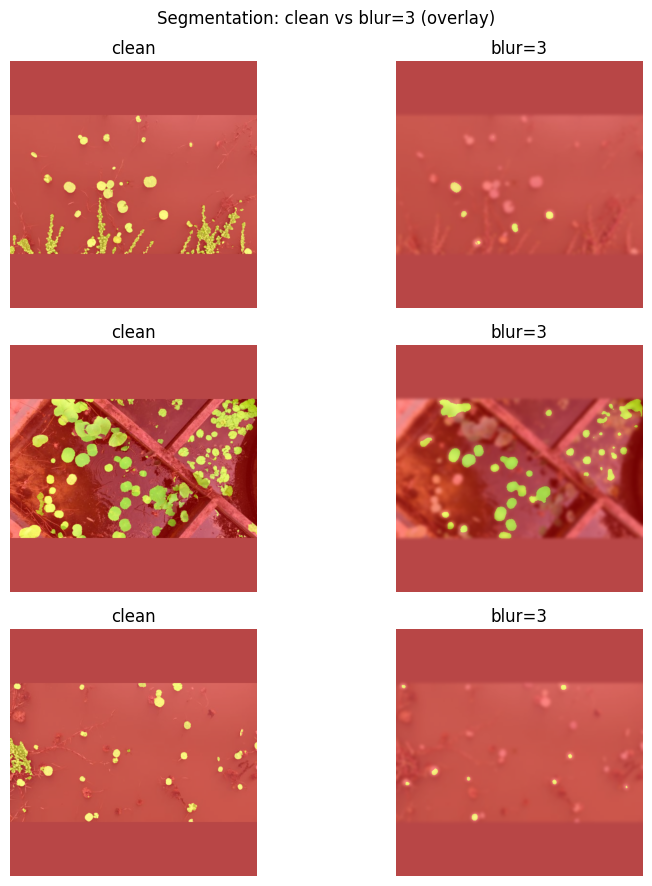

In [14]:
def show_presence_examples(rows, kind="blur", v=2):
    fig, axs = plt.subplots(2, 3, figsize=(9,6))
    samples = rows.sample(min(6, len(rows)), random_state=42)
    for i, (_,r) in enumerate(samples.iterrows()):
        img0 = Image.open(r.image_path).convert("RGB").resize((SIZE_CLS,SIZE_CLS))
        img1 = corrupt(img0, **({kind: v} if kind!="jpeg_q" else {"jpeg_q": v}))
        for col, img in enumerate([img0, img1]):
            x = pil_to_tensor_cls(img).unsqueeze(0).to(device)
            p = torch.sigmoid(presence_model(x)).item()
            ax = axs[i//3, col + (0 if col==0 else 1)]
            ax.imshow(img); ax.axis("off")
            ax.set_title(("clean" if col==0 else f"{kind}={v}") + f"\nP(h)= {p:.2f}")
        axs[i//3, 2].axis("off")
    fig.suptitle(f"Presence: clean vs {kind}={v}")
    plt.tight_layout(); plt.show()

def show_seg_examples(rows, kind="blur", v=2, t=0.4):
    samples = rows.sample(min(3, len(rows)), random_state=7)
    plt.figure(figsize=(9, 9))
    for i, (_,r) in enumerate(samples.iterrows()):
        img0 = Image.open(r.image_path).convert("RGB")
        msk0 = Image.open(r.mask_path).convert("L")
        img1 = corrupt(img0, **({kind: v} if kind!="jpeg_q" else {"jpeg_q": v}))
        for j, img in enumerate([img0, img1]):
            x, y = pil_to_tensor_seg(img, msk0)
            x = x.unsqueeze(0).to(device); y = y.to(device)
            with torch.no_grad():
                pr = (torch.sigmoid(seg_model(x)) > t).float().squeeze().cpu().numpy()
            base = x.squeeze().permute(1,2,0).cpu().numpy()
            mean = np.array([0.485,0.456,0.406]); std = np.array([0.229,0.224,0.225])
            base = np.clip(base*std + mean, 0, 1)
            ax = plt.subplot(len(samples), 2, i*2 + j + 1)
            ax.imshow(base); ax.imshow(pr, alpha=0.45, cmap="autumn")
            ax.axis("off"); ax.set_title("clean" if j==0 else f"{kind}={v}")
    plt.suptitle(f"Segmentation: clean vs {kind}={v} (overlay)")
    plt.tight_layout(); plt.show()

# Usage examples:
show_presence_examples(val_cls_df, kind="blur", v=3)
show_seg_examples(val_seg_df, kind="blur", v=3, t=0.4)

### Find new best threshold under corruption

In [15]:
def best_threshold_under(model, rows, kind="blur", v=2):
    ys, ps = [], []
    with torch.no_grad():
        for _, r in rows.iterrows():
            img = Image.open(r.image_path).convert("RGB").resize((SIZE_CLS,SIZE_CLS))
            img = corrupt(img, **({kind:v} if kind!="jpeg_q" else {"jpeg_q": v}))
            x = pil_to_tensor_cls(img).unsqueeze(0).to(device)
            ps.append(torch.sigmoid(model(x)).item())
            ys.append(int(r.has_hyacinth))
    ys, ps = np.array(ys), np.array(ps)
    fpr, tpr, thr = roc_curve(ys, ps)
    t_j = float(thr[np.argmax(tpr - fpr)])
    cands = np.linspace(0.05,0.95,19)
    t_f1 = float(cands[np.argmax([f1_score(ys,(ps>t).astype(int)) for t in cands])])
    return t_j, t_f1

t_j, t_f1 = best_threshold_under(presence_model, val_cls_df, kind="blur", v=3)
print("Best thresholds @ blur=3 → YoudenJ:", round(t_j,3), " F1:", round(t_f1,3))

Best thresholds @ blur=3 → YoudenJ: 1.0  F1: 0.95
